# XU Method – Entropy-Based Anomaly Detection on CTU-13

Ce Notebook démontre l'approche XU, basée sur l'entropie, sur un dataset de type CTU-13.

### Étapes principales :
1. Import & Setup
2. Chargement de données (fichier binetflow)
3. Préprocessing (simplification des labels)
4. **Fonction `XU_algorithm`** qui calcule l'entropie par IP source
5. Application de la fonction XU et visualisation des résultats
6. Évaluation (matrice de confusion, précision, rappel, etc.)


## 1. Import & Setup

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import json

%matplotlib inline
sns.set()
print("Libraries loaded.")

Libraries loaded.


In [50]:
from IPython.display import display, HTML

def display_scrollable_dataframe(df, max_height=400):
    display(HTML(df.to_html(notebook=True)))
    display(HTML(f"""
    <style>
    table {{
        display: block;
        max-height: {max_height}px;
        overflow-y: scroll;
        border: 1px solid #ccc;
    }}
    </style>
    """))

## 2. Chargement de données
Nous supposons que vous avez déjà un fichier `.binetflow` extrait de CTU-13 (e.g. scenario 5).

In [ ]:
import re

# Chemin du fichier d'origine
input_file = 'dataset\capture20110817.pcap.netflow.labeled'
# Chemin du fichier de sortie
output_file = 'dataset\capture20110817.pcap.netflow.labeled.csv'

with open(input_file, 'r', encoding='utf-8', errors='replace') as f:
    lines = f.readlines()

# Pour chaque ligne, remplace tous les groupes d'espaces par une virgule
converted_lines = [re.sub(r'\s+', ',', line.strip()) for line in lines]

# Écrit le résultat dans un nouveau fichier
with open(output_file, 'w', encoding='utf-8') as f:
    for line in converted_lines:
        f.write(line + "\n")

print("Fichier converti en CSV sauvegardé sous", output_file)


In [72]:
# Chemin vers un fichier .binetflow
data_path = "dataset\capture20110817_9.binetflow"

df = pd.read_csv(data_path, sep=',', on_bad_lines='skip')
print(f"Data shape: {df.shape}")
df.head(20)

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\kira\AppData\Local\Temp\ipykernel_16880\450075541.py:2: SyntaxWarning: invalid escape sequence '\c'
  data_path = "dataset\capture20110817_9.binetflow"


Data shape: (2087508, 15)


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/17 12:01:12.984851,0.976560,tcp,93.45.141.223,2254,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
1,2011/08/17 12:01:15.616709,0.950668,tcp,84.16.60.37,64136,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
2,2011/08/17 12:01:23.209772,1.006908,tcp,94.44.197.227,3844,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,flow=Background-TCP-Attempt
3,2011/08/17 12:01:24.216680,1.000400,tcp,94.44.197.227,3844,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,flow=Background-TCP-Attempt
4,2011/08/17 12:03:27.216922,1.093291,tcp,147.32.3.51,1656,->,147.32.87.22,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
5,2011/08/17 12:03:50.442721,0.982337,tcp,93.45.211.241,4332,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
6,2011/08/17 12:04:26.344286,1.636698,tcp,85.114.48.118,35566,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,flow=Background-TCP-Attempt
7,2011/08/17 12:06:55.248668,0.993942,tcp,85.114.48.118,41173,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,flow=Background-TCP-Attempt
8,2011/08/17 12:08:42.994651,8.159175,tcp,95.143.208.138,19797,->,147.32.86.165,80,SR_SA,0.0,0.0,5,364,216,flow=Background-TCP-Established
9,2011/08/17 12:08:50.682989,1.140232,tcp,93.47.141.213,49669,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt


## 3. Préprocessing / Data Exploration
On convertit les labels (Botnet vs Normal).

In [73]:
def preprocess_binetflows(df):
    """
    Harmonise le format du dataset aux standards des algorithmes XU et de classification utilisés précédemment,
    en renommant uniquement les colonnes nécessaires, sans toucher aux colonnes :
    'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes'.

    Conserve le label d'origine dans une colonne 'Label_description'.

    Paramètres :
    - df : DataFrame brut

    Retour :
    - df_clean : DataFrame nettoyé et harmonisé
    """

    print("🔧 Renommage des colonnes au format standard (sans toucher à 'State', 'sTos', 'dTos', etc)...")
    rename_map = {
        'StartTime': 'flow_start',
        'Dur': 'Durat',
        'Proto': 'Prot',
        'SrcAddr': 'SrcIP',
        'Sport': 'SrcPort',
        'Dport': 'DstPort',
        'Dir': 'Direc',  # si tu veux garder l'info de direction
        'DstAddr': 'DstIP'
        # Pas de renommage pour : State, sTos, dTos, TotPkts, TotBytes, SrcBytes
    }

    df_clean = df.rename(columns=rename_map)

    # Conserver les labels d'origine dans une nouvelle colonne
    print("📋 Sauvegarde du label d'origine dans 'Label_description'...")
    df_clean['Label_description'] = df_clean['Label'].astype(str)

    # Harmonisation des labels simplifiés
    print("🧼 Nettoyage des labels (uniquement Background, Normal, Botnet)...")
    df_clean['Label'] = df_clean['Label_description'].apply(lambda x: (
        'Botnet' if 'Botnet' in x else
        'Normal' if 'Normal' in x else
        'Background'
    ))

    # Conversion de flow_start en datetime
    if not pd.api.types.is_datetime64_any_dtype(df_clean['flow_start']):
        print("📅 Conversion de 'flow_start' en datetime...")
        df_clean['flow_start'] = pd.to_datetime(df_clean['flow_start'], errors='coerce')

    print("✅ Dataset prêt pour les traitements XU et classification.")
    return df_clean


In [74]:
df = preprocess_binetflows(df)
display_scrollable_dataframe(df.head(20))

🔧 Renommage des colonnes au format standard (sans toucher à 'State', 'sTos', 'dTos', etc)...
📋 Sauvegarde du label d'origine dans 'Label_description'...
🧼 Nettoyage des labels (uniquement Background, Normal, Botnet)...
📅 Conversion de 'flow_start' en datetime...
✅ Dataset prêt pour les traitements XU et classification.


,flow_start,Durat,Prot,SrcIP,SrcPort,Direc,DstIP,DstPort,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Label_description
0,2011-08-17 12:01:12.984851,0.976560,tcp,93.45.141.223,2254,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt
1,2011-08-17 12:01:15.616709,0.950668,tcp,84.16.60.37,64136,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt
2,2011-08-17 12:01:23.209772,1.006908,tcp,94.44.197.227,3844,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,Background,flow=Background-TCP-Attempt
3,2011-08-17 12:01:24.216680,1.000400,tcp,94.44.197.227,3844,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,Background,flow=Background-TCP-Attempt
4,2011-08-17 12:03:27.216922,1.093291,tcp,147.32.3.51,1656,->,147.32.87.22,10010,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt
5,2011-08-17 12:03:50.442721,0.982337,tcp,93.45.211.241,4332,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt
6,2011-08-17 12:04:26.344286,1.636698,tcp,85.114.48.118,35566,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,Background,flow=Background-TCP-Attempt
7,2011-08-17 12:06:55.248668,0.993942,tcp,85.114.48.118,41173,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,Background,flow=Background-TCP-Attempt
8,2011-08-17 12:08:42.994651,8.159175,tcp,95.143.208.138,19797,->,147.32.86.165,80,SR_SA,0.0,0.0,5,364,216,Background,flow=Background-TCP-Established
9,2011-08-17 12:08:50.682989,1.140232,tcp,93.47.141.213,49669,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,Background,flow=Background-TCP-Attempt


In [ ]:
display_scrollable_dataframe(df.sort_values(by='flow_start').head(50))

In [ ]:
display_scrollable_dataframe(df.sort_values(by='flow_start')[df["Label"] == "Botnet"].head(50))

In [ ]:
def hist_of_label_values(df):
    """
    Affiche un histogramme de la répartition des labels dans le DataFrame,
    avec les pourcentages affichés sur les barres.
    
    Paramètres :
    - df : pd.DataFrame contenant une colonne 'Label' avec les valeurs 
           'Background', 'Normal' et 'Botnet'.
    
    Affichage :
    - Un histogramme avec les pourcentages sur les barres.
    - Un dictionnaire affiché contenant les pourcentages.
    """
    # Regroupement des valeurs
    label_values = df['Label'].value_counts()

    # Somme des catégories
    background_count = sum(label_values[label] for label in label_values.index if "Background" in label)
    normal_count = sum(label_values[label] for label in label_values.index if "Normal" in label)
    botnet_count = sum(label_values[label] for label in label_values.index if "Botnet" in label)
    
    # Dictionnaire des comptages
    label_repartition = {
        "Background traffic": background_count, 
        "Normal traffic": normal_count, 
        "Botnet traffic": botnet_count
    }

    # Calcul du total et des pourcentages
    total_traffic = sum(label_repartition.values())
    percentage_of_traffic = {k: round((v / total_traffic) * 100, 2) for k, v in label_repartition.items()}

    # Affichage de l'histogramme
    fig, ax = plt.subplots(figsize=(7,5))
    bars = ax.bar(label_repartition.keys(), label_repartition.values(), color=['gray', 'blue', 'red'])

    # Ajout des pourcentages au-dessus des barres
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_traffic) * 100
        ax.text(bar.get_x() + bar.get_width()/2, height + total_traffic * 0.02, 
                f"{percentage:.2f}%", ha='center', fontsize=12, fontweight='bold')

    # Amélioration du visuel
    ax.set_ylabel("Nombre de flux", fontsize=12)
    ax.set_title("Répartition du trafic par catégorie", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()


In [75]:
df.value_counts("Label")

Label
Background    1872554
Botnet         184987
Normal          29967
Name: count, dtype: int64

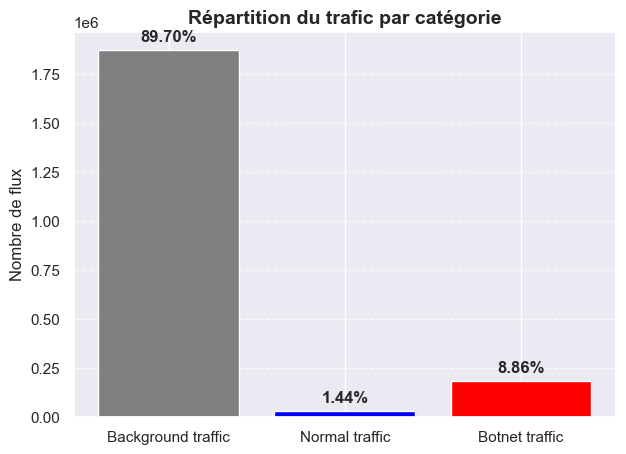

In [76]:
hist_of_label_values(df)

In [ ]:
def plot_label_distribution_separated(df_classified_netflows, time_col='TimeWindow', x_tick_spacing=5, label_to_show=['Botnet', 'Normal', 'Background']):
    """
    Affiche un graphe séparé (non empilé) du nombre de flux pour chaque label par TimeWindow.

    Paramètres :
    - df_classified_netflows : DataFrame contenant 'TimeWindow' et 'Label'
    - time_col : nom de la colonne temporelle (par défaut 'TimeWindow')
    - x_tick_spacing : espacement des ticks X (ex: 5 = 1 tick toutes les 5 TimeWindows)
    """
    print("📊 ➤ Calcul de la distribution des labels par TimeWindow (graphes séparés)...")

    # Conversion TimeWindow en label lisible
    df_classified_netflows['TimeLabel'] = df_classified_netflows[time_col].dt.strftime('%H:%M')

    # Comptage des labels par TimeWindow
    label_counts = df_classified_netflows.groupby(['TimeLabel', 'Label']).size().unstack(fill_value=0)

    # Ajouter les labels manquants si nécessaire
    for label in label_to_show:
        if label not in label_counts.columns:
            label_counts[label] = 0

    label_counts = label_counts[label_to_show]

    # Création des sous-graphes
    n = len(label_to_show)
    fig, axes = plt.subplots(n, 1, figsize=(18, 4 * n), sharex=True)

    if n == 1:
        axes = [axes]

    # Espacement des ticks X
    x_ticks = np.arange(0, len(label_counts), x_tick_spacing)
    x_labels = label_counts.index[x_ticks]

    for i, label in enumerate(label_to_show):
        axes[i].bar(label_counts.index, label_counts[label], color=('red' if label == 'Botnet' else 'blue' if label == 'Normal' else 'gray'))
        axes[i].set_title(f"📊 Activité '{label}' au fil du temps", fontsize=14)
        axes[i].set_ylabel("Nombre de flux")
        axes[i].grid(True, axis='y', linestyle='--', alpha=0.6)
        axes[i].set_xticks(x_ticks)
        axes[i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

    axes[-1].set_xlabel("Heure (TimeWindow)", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_label_distribution_separated(df, time_col="flow_start", x_tick_spacing=4, label_to_show=['Botnet', 'Normal', 'Background'])



In [77]:
pd.DataFrame(df[df["Label"] == "Botnet"]["SrcIP"].value_counts()).head(20)

,count
SrcIP,
147.32.84.165,22792
147.32.84.192,20305
147.32.84.204,18783
147.32.84.191,18774
147.32.84.206,18553
147.32.84.193,17961
147.32.84.208,17909
147.32.84.205,17535
147.32.84.209,16376


## 4. Fonction `XU_algorithm`
Cette fonction va :
1. Agréger par IP source.
2. Calculer l'entropie normalisée (ports source, ports destination, IP destination).
3. Calculer le score `score = H(DstIP) - H(DstPort)`.
4. Déterminer un seuil via le quantile (par défaut 95ᵉ percentile).
5. Retourner un DataFrame par IP avec colonnes d'entropie, le score, la prédiction, etc.

In [121]:
def compute_relative_uncertainty(prob_dist):
    probs = np.array(prob_dist)
    if len(probs) <= 1:
        return 0.0
    entropy = -np.sum(probs * np.log2(probs + 1e-12))
    max_entropy = np.log2(len(probs))
    return entropy / max_entropy

def extract_significant_clusters_with_live_plot(df, column='SrcIP', alpha0=0.02, beta=0.9, debug=False):
    """
    Extraction des clusters significatifs + affichage final des courbes à la fin de l’algorithme.
    """
    print(f"📊 ➤ Extraction des clusters significatifs sur colonne '{column}'")

    freqs = df[column].value_counts(normalize=True)
    A = freqs.index.tolist()
    PA = freqs.to_dict()

    S = set()
    R = set(A)
    k = 0
    alpha = alpha0

    log = []
    total_values_list = []
    significant_values_list = []
    alpha_list = []

    PR = [PA[val] for val in R]
    theta = compute_relative_uncertainty(PR)

    while theta <= beta:
        alpha = alpha0 * (0.5 ** k)
        k += 1

        move_to_S = {val for val in R if PA[val] >= alpha}
        S.update(move_to_S)
        R -= move_to_S

        # ✅ Normalisation de PR
        PR_probs = [PA[val] for val in R]
        PR_probs = np.array(PR_probs)
        PR_probs = PR_probs / PR_probs.sum() if PR_probs.sum() > 0 else np.array([1.0])  # éviter division par 0

        theta = compute_relative_uncertainty(PR_probs)

        if debug:
            print(f"\n🔁 Iteration {k}")
            print(f"  ➤ Alpha: {round(alpha, 5)}")
            print(f"  ➤ RU(R): {round(theta, 5)}")
            print(f"  ➤ |S|={len(S)} | |R|={len(R)} | Move_to_S={len(move_to_S)}")

        total_values_list.append(len(A))
        significant_values_list.append(len(S))
        alpha_list.append(alpha)
        log.append({
            'Iteration': k,
            'Alpha': alpha,
            'RU_remaining': theta,
            'Total_Values': len(A),
            'Significant_Values': len(S),
        })

    alpha_star = alpha

    # Ajout des clusters dans le dataset
    df_clustered = df.copy()
    df_clustered['ClusterType'] = df_clustered[column].apply(lambda x: 'Significatif' if x in S else 'Bruit')
    df_log = pd.DataFrame(log)

    print(f"\n✅ Extraction terminée : {len(S)} clusters significatifs extraits. α* final = {alpha_star}")
    print(S)
    # 📈 Plots à la fin seulement
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    iterations = list(range(1, k + 1))

    ax1.plot(iterations, total_values_list, 'b--', label='Total values')
    ax1.plot(iterations, significant_values_list, 'r-', label='Significant values')
    ax1.set_yscale('log')
    ax1.set_title(" Total vs Significant Values")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Number of values (log scale)")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(iterations, alpha_list, 'r-', label='Alpha threshold')
    ax2.set_title(" Évolution du seuil α")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Alpha")
    ax2.grid(True)

    plt.show()

    return S, R, alpha_star, df_clustered, df_log


In [107]:
def normalized_entropy(series):
    """
    Calcule l'entropie normalisée (Relative Uncertainty - RU).
    """
    counts = series.value_counts(normalize=True, dropna=False)
    entropy = -(counts * np.log2(counts + 1e-12)).sum()
    distinct = len(counts)
    total = len(series)

    if distinct <= 1 or total <= 1:
        return 0.0

    max_entropy = np.log2(min(distinct, total))
    return float(entropy / max_entropy)

def XU_algorithm(df, ref_profiles=None):
    """
    Algorithme XU.
    Calcul des distances comme la somme des carrés des différences d'entropies normalisées (RU).

    Paramètres :
    - df : DataFrame NetFlows (doit contenir 'SrcIP', 'SrcPort', 'DstPort', 'DstIP', 'Label')
    - ref_profiles : dict des profils de référence : {'nom': [RU_srcPort, RU_dstPort, RU_dstIP]}

    Retour :
    - df_features : DataFrame contenant RU, distances aux profils, et score d’anomalie
    """

    if ref_profiles is None or ref_profiles == {}:
        ref_profiles = {
            'server': np.array([0.2, 0.9, 0.5]),
            'client': np.array([0.9, 0.2, 0.2]),
            'zero':   np.zeros(3)
        }

    results = []
    ip_groups = df.groupby('SrcIP')

    print(f"➤ Traitement de {len(ip_groups)} adresses IP sources...")

    for src_ip, df_src in tqdm(ip_groups, desc="Analyse XU"):
        ru_srcport = normalized_entropy(df_src['SrcPort'].fillna('N/A'))
        ru_dstport = normalized_entropy(df_src['DstPort'].fillna('N/A'))
        ru_dstip   = normalized_entropy(df_src['DstIP'].fillna('N/A'))

        label = 'Botnet' if 'Botnet' in df_src['Label'].unique() else (
                'Normal' if 'Normal' in df_src['Label'].unique() else 'Background'
        )

        ru_vector = np.array([ru_srcport, ru_dstport, ru_dstip])

        distances = {}
        for profile_name, profile_vector in ref_profiles.items():
            dist = ((ru_vector - profile_vector) ** 2).sum()  # sans racine carrée
            distances[f'Distance_{profile_name.capitalize()}'] = dist

        # Anomaly Score = minimum distance aux profils connus
        min_distance = min(distances.values())

        result_row = {
            'SrcIP': src_ip,
            'RU_SrcPort': ru_srcport,
            'RU_DstPort': ru_dstport,
            'RU_DstIP': ru_dstip,
            'AnomalyScore': min_distance,
            'Label': label
        }
        result_row.update(distances)
        results.append(result_row)

    df_features = pd.DataFrame(results)
    print("✅ XU terminé.")
    return df_features



def apply_threshold_and_categorize_ru(df_features, threshold=0.5, epsilon_dict=None):
    """
    - Applique le seuil de classification sur la colonne 'Mean_Distance'
    - Catégorise chaque RU en Low (0), Medium (1), High (2) selon epsilon_dict
    - Insère les colonnes RU_*_Level juste après leur colonne RU_* correspondante

    Paramètres :
    - df_features : DataFrame avec les colonnes RU_* et Mean_Distance
    - threshold : seuil pour prédiction de 'Botnet' ou 'Normal'
    - epsilon_dict : dictionnaire des epsilon, ex: {'RU_SrcPort': 0.2, 'RU_DstPort': 0.2, 'RU_DstIP': 0.3}

    Retour :
    - df : DataFrame enrichi avec 'Predicted' + colonnes de niveau
    """

    df = df_features.copy()
    df['Predicted'] = df['AnomalyScore'].apply(lambda d: 'Botnet' if d < threshold else 'Normal')

    if epsilon_dict is None:
        epsilon_dict = {
            'RU_SrcPort': 0.2,
            'RU_DstPort': 0.2,
            'RU_DstIP': 0.3
        }

    def categorize_ru(ru_value, epsilon):
        if ru_value <= epsilon:
            return 0  # Low
        elif ru_value >= 1 - epsilon:
            return 2  # High
        else:
            return 1  # Medium

    # Insérer chaque RU_Level juste après la RU correspondante
    for col in ['RU_SrcPort', 'RU_DstPort', 'RU_DstIP']:
        if col in df.columns:
            level_col = col + '_Level'
            df[level_col] = df[col].apply(lambda x: categorize_ru(x, epsilon_dict.get(col, 0.2)))
            
            # Réorganiser les colonnes : insérer level_col juste après col
            cols = list(df.columns)
            col_idx = cols.index(col)
            # Retirer puis insérer à la bonne position
            cols.remove(level_col)
            cols.insert(col_idx + 1, level_col)
            df = df[cols]

    return df




## 5. Application
On applique `XU_algorithm` à notre DataFrame `df`, puis on regarde le résultat.

In [ ]:
custom_profiles = {
    # Comportements typiques de botnets/scanners identifiés :
    
    # BC2 [0,0,2] → Scan horizontal basique / botnet scanner simple
    'scanner_simple': np.array([0.1, 0.1, 0.9]),

    # BC20 [2,0,2] → Scanner bruyant, srcPrt aléatoires, dstIP massifs
    'scanner_bruyant': np.array([0.9, 0.1, 0.9]),

    # BC8 [0,2,2] → Réponse d’une victime potentiellement exposée à divers scanners
    'victime_multiattaque': np.array([0.1, 0.9, 0.9]),

    # BC5 [0,1,2] → Scan un peu plus varié, intermédiaire
    'scanner_intermediaire': np.array([0.1, 0.5, 0.9]),

    # BC23 [2,1,2] → Profil de service fortement ciblé par des scanners massifs
    'cible_botnet': np.array([0.9, 0.5, 0.9]),
}


df_features = XU_algorithm(df, ref_profiles=custom_profiles)


📊 ➤ Extraction des clusters significatifs sur colonne 'SrcIP'

✅ Extraction terminée : 20 clusters significatifs extraits. α* final = 0.005
{'147.32.84.118', '147.32.84.59', '147.32.84.170', '147.32.84.205', '147.32.84.204', '147.32.86.165', '147.32.84.165', '147.32.84.229', '147.32.84.138', '147.32.84.206', '147.32.84.94', '147.32.84.191', '147.32.85.34', '147.32.85.25', '147.32.84.208', '147.32.84.193', '147.32.84.207', '147.32.84.192', '147.32.86.20', '147.32.84.209'}


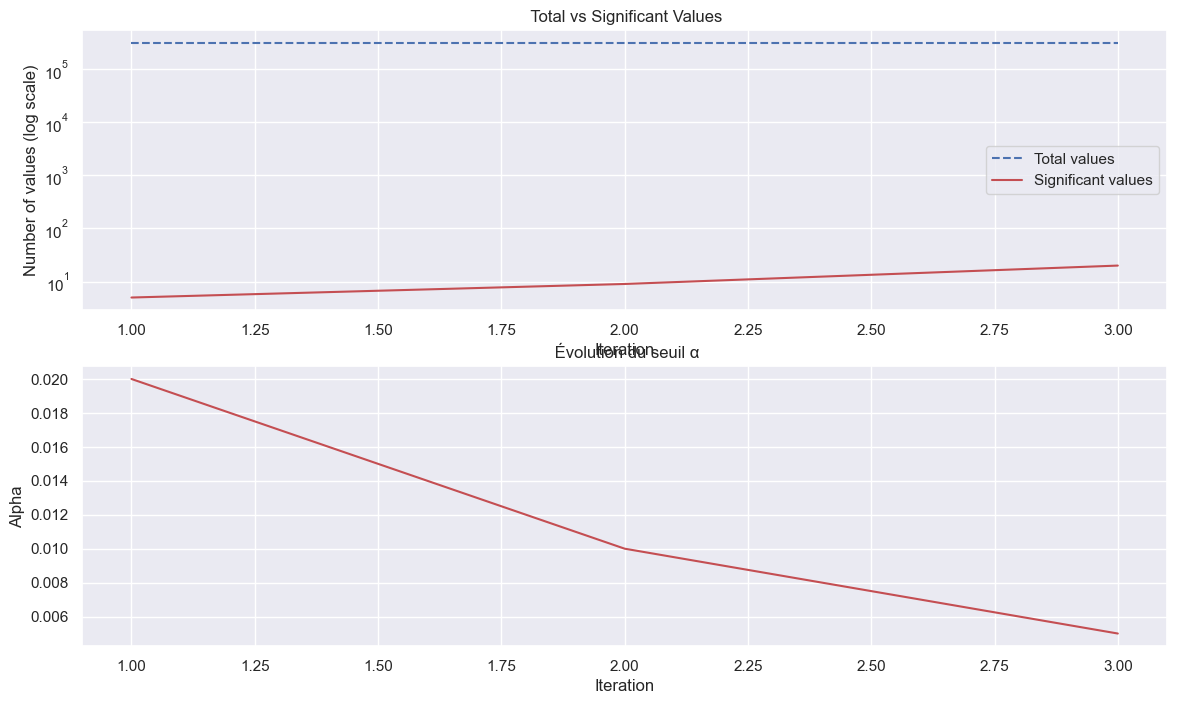


🔍 Nombre de lignes retenues pour l’analyse XU : 1170541
➤ Traitement de 20 adresses IP sources...


Analyse XU:   0%|          | 0/20 [00:00<?, ?it/s]

✅ XU terminé.


In [123]:
# --- 1. Étape : Extraction des clusters significatifs sur une colonne (par ex. 'SrcIP')
S, R, alpha_star, df_clustered, df_log = extract_significant_clusters_with_live_plot(
    df, column='SrcIP', alpha0=0.02, beta=0.8, debug=False
)

# --- 2. Filtrage du dataset : uniquement les lignes appartenant aux clusters significatifs
df_significatif = df_clustered[df_clustered['ClusterType'] == 'Significatif']

print(f"\n🔍 Nombre de lignes retenues pour l’analyse XU : {len(df_significatif)}")

# --- 3. Application de l’algorithme XU uniquement sur ce sous-ensemble

custom_profiles = {
    # Comportements typiques de botnets/scanners identifiés :
    
    # BC2 [0,0,2] → Scan horizontal basique / botnet scanner simple
    'scanner_simple': np.array([0.1, 0.1, 0.9]),

    # BC20 [2,0,2] → Scanner bruyant, srcPrt aléatoires, dstIP massifs
    'scanner_bruyant': np.array([0.9, 0.1, 0.9]),

    # BC8 [0,2,2] → Réponse d’une victime potentiellement exposée à divers scanners
    'victime_multiattaque': np.array([0.1, 0.9, 0.9]),

    # BC5 [0,1,2] → Scan un peu plus varié, intermédiaire
    'scanner_intermediaire': np.array([0.1, 0.5, 0.9]),

    # BC23 [2,1,2] → Profil de service fortement ciblé par des scanners massifs
    'cible_botnet': np.array([0.9, 0.5, 0.9]),
}

df_features = XU_algorithm(df_significatif, ref_profiles=custom_profiles)


In [110]:
epsilon_dict = {
    'RU_SrcPort': 0.2,
    'RU_DstPort': 0.2,
    'RU_DstIP': 0.3
}

df_classified = apply_threshold_and_categorize_ru(df_features, threshold=0.4, epsilon_dict=epsilon_dict)

display_scrollable_dataframe(df_classified.head(20), max_height=400)

,SrcIP,RU_SrcPort,RU_SrcPort_Level,RU_DstPort,RU_DstPort_Level,RU_DstIP,RU_DstIP_Level,AnomalyScore,Label,Distance_Scanner_simple,Distance_Scanner_bruyant,Distance_Victime_multiattaque,Distance_Scanner_intermediaire,Distance_Cible_botnet,Predicted
0,147.32.84.118,0.850710,2,0.301609,1,0.792113,2,0.053428,Normal,0.615851,0.054715,0.933276,0.614563,0.053428,Botnet
1,147.32.84.123,0.995805,2,0.373292,1,0.645056,1,0.090230,Background,0.942152,0.148864,1.144884,0.883518,0.090230,Botnet
2,147.32.84.132,0.993029,2,0.422940,1,0.476691,1,0.193783,Background,1.080981,0.292135,1.204276,0.982628,0.193783,Botnet
3,147.32.84.134,0.994022,2,0.420982,1,0.503649,1,0.172178,Normal,1.059399,0.268964,1.185829,0.962614,0.172178,Botnet
4,147.32.84.138,0.995950,2,0.012302,0,0.016713,0,0.797094,Normal,1.590614,0.797094,2.370931,1.820773,1.027252,Normal
5,147.32.84.164,0.995482,2,0.361496,1,0.393108,1,0.285240,Normal,1.127207,0.334437,1.348814,1.078011,0.285240,Botnet
6,147.32.84.165,0.690713,1,0.325332,1,0.369876,1,0.355342,Botnet,0.680748,0.375607,0.960216,0.660482,0.355342,Botnet
7,147.32.84.170,0.991552,2,0.488216,1,0.408422,1,0.250169,Normal,1.187225,0.400742,1.206079,1.036652,0.250169,Botnet
8,147.32.84.181,0.995110,2,0.412766,1,0.478790,1,0.194074,Background,1.076463,0.284287,1.216037,0.986250,0.194074,Botnet
9,147.32.84.184,0.905066,2,0.341916,1,0.484452,1,0.197696,Background,0.879334,0.231229,1.132269,0.845801,0.197696,Botnet


In [111]:
display_scrollable_dataframe(df_classified[df_classified["Label"] != "Background"].head(20), max_height=400)

,SrcIP,RU_SrcPort,RU_SrcPort_Level,RU_DstPort,RU_DstPort_Level,RU_DstIP,RU_DstIP_Level,AnomalyScore,Label,Distance_Scanner_simple,Distance_Scanner_bruyant,Distance_Victime_multiattaque,Distance_Scanner_intermediaire,Distance_Cible_botnet,Predicted
0,147.32.84.118,0.850710,2,0.301609,1,0.792113,2,0.053428,Normal,0.615851,0.054715,0.933276,0.614563,0.053428,Botnet
3,147.32.84.134,0.994022,2,0.420982,1,0.503649,1,0.172178,Normal,1.059399,0.268964,1.185829,0.962614,0.172178,Botnet
4,147.32.84.138,0.995950,2,0.012302,0,0.016713,0,0.797094,Normal,1.590614,0.797094,2.370931,1.820773,1.027252,Normal
5,147.32.84.164,0.995482,2,0.361496,1,0.393108,1,0.285240,Normal,1.127207,0.334437,1.348814,1.078011,0.285240,Botnet
6,147.32.84.165,0.690713,1,0.325332,1,0.369876,1,0.355342,Botnet,0.680748,0.375607,0.960216,0.660482,0.355342,Botnet
7,147.32.84.170,0.991552,2,0.488216,1,0.408422,1,0.250169,Normal,1.187225,0.400742,1.206079,1.036652,0.250169,Botnet
12,147.32.84.191,0.692624,1,0.378322,1,0.442651,1,0.266978,Botnet,0.637834,0.329636,0.832519,0.575177,0.266978,Botnet
13,147.32.84.192,0.710130,1,0.446048,1,0.414295,1,0.274871,Botnet,0.727917,0.391709,0.814241,0.611079,0.274871,Botnet
14,147.32.84.193,0.693080,1,0.405152,1,0.432517,1,0.270352,Botnet,0.663402,0.354474,0.815159,0.579280,0.270352,Botnet
15,147.32.84.204,0.723172,1,0.452771,1,0.426865,1,0.257356,Botnet,0.736648,0.379573,0.812213,0.614431,0.257356,Botnet


C:\Users\kira\AppData\Local\Temp\ipykernel_16880\1694362782.py:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\kira\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


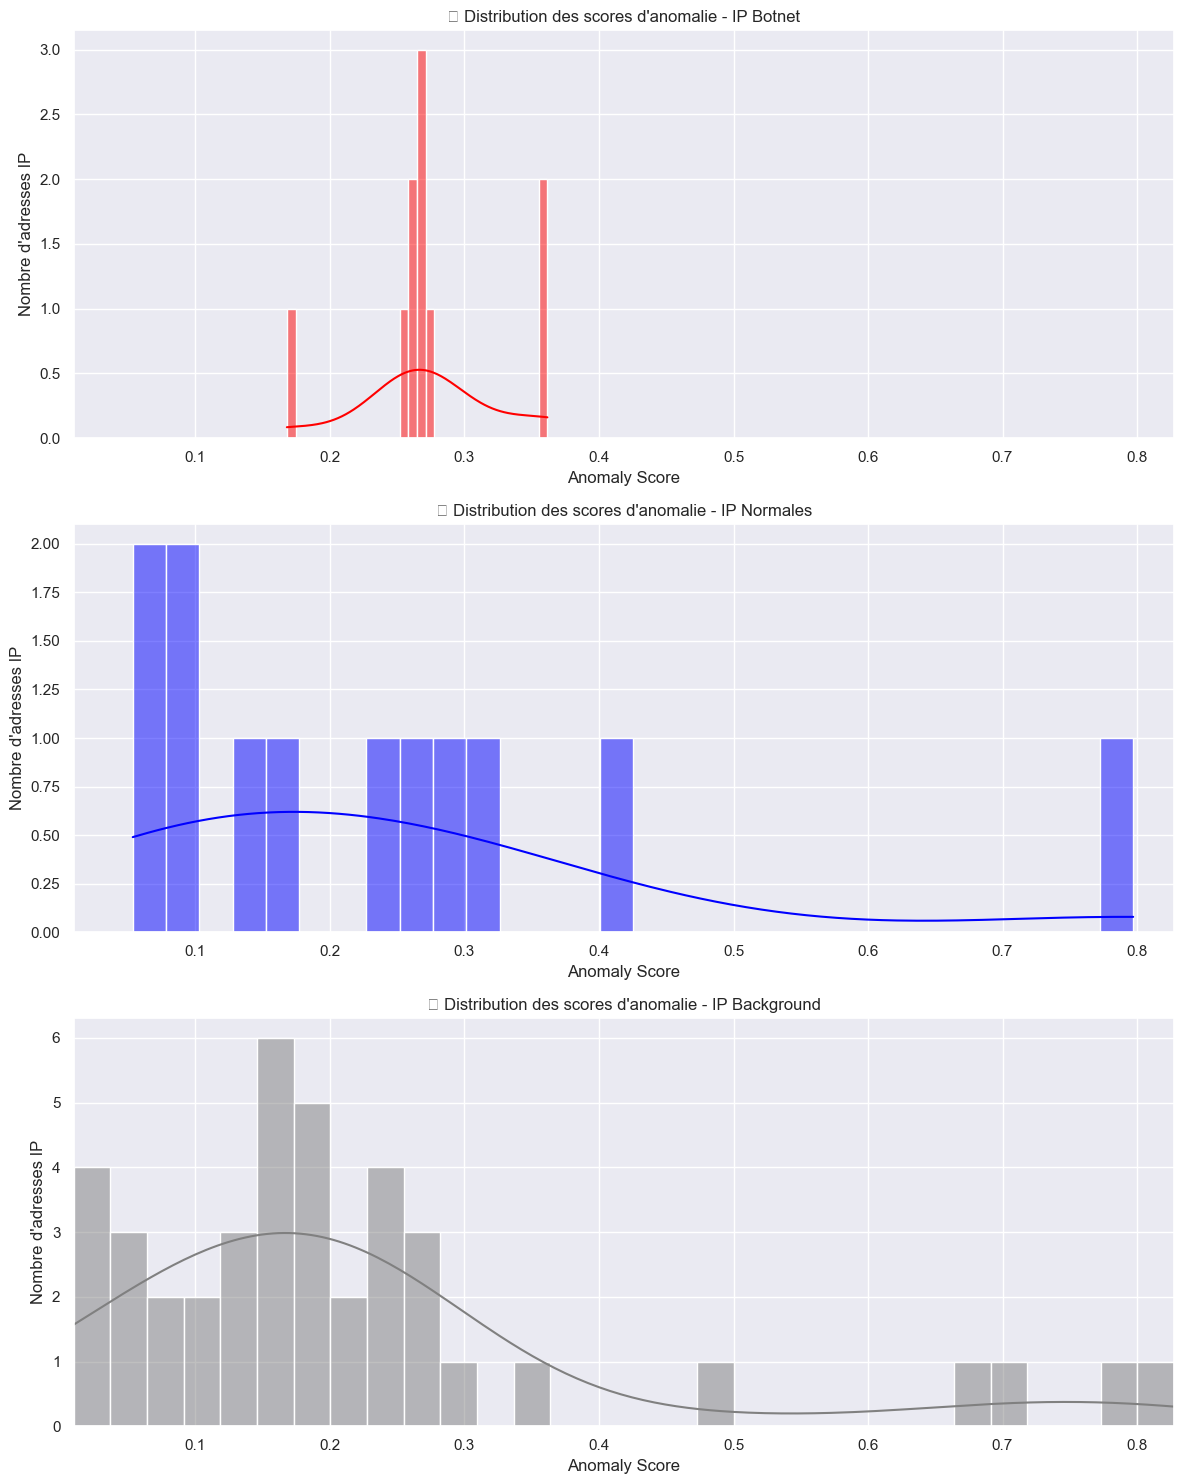

In [ ]:
# Filtrer les IP selon le label
botnet_scores_df = df_classified[df_classified['Label'] == 'Botnet'][['SrcIP', 'AnomalyScore']].reset_index(drop=True)
normal_scores_df = df_classified[df_classified['Label'] == 'Normal'][['SrcIP', 'AnomalyScore']].reset_index(drop=True)
background_scores_df = df_classified[df_classified['Label'] == 'Background'][['SrcIP', 'AnomalyScore']].reset_index(drop=True)

# ➤ Calcul des bornes communes d'AnomalyScore
min_score = min(
    botnet_scores_df['AnomalyScore'].min(),
    normal_scores_df['AnomalyScore'].min(),
    background_scores_df['AnomalyScore'].min()
)

max_score = max(
    botnet_scores_df['AnomalyScore'].max(),
    normal_scores_df['AnomalyScore'].max(),
    background_scores_df['AnomalyScore'].max()
)

# Créer les subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Histogramme Botnet
sns.histplot(botnet_scores_df['AnomalyScore'], bins=30, kde=True, ax=axes[0], color='red')
axes[0].set_title("📊 Distribution des scores d'anomalie - IP Botnet")
axes[0].set_xlabel("Anomaly Score")
axes[0].set_ylabel("Nombre d'adresses IP")
axes[0].set_xlim(min_score, max_score)
axes[0].grid(True)

# Histogramme Normal
sns.histplot(normal_scores_df['AnomalyScore'], bins=30, kde=True, ax=axes[1], color='blue')
axes[1].set_title("📊 Distribution des scores d'anomalie - IP Normales")
axes[1].set_xlabel("Anomaly Score")
axes[1].set_ylabel("Nombre d'adresses IP")
axes[1].set_xlim(min_score, max_score)
axes[1].grid(True)

# Histogramme Background
sns.histplot(background_scores_df['AnomalyScore'], bins=30, kde=True, ax=axes[2], color='gray')
axes[2].set_title("📊 Distribution des scores d'anomalie - IP Background")
axes[2].set_xlabel("Anomaly Score")
axes[2].set_ylabel("Nombre d'adresses IP")
axes[2].set_xlim(min_score, max_score)
axes[2].grid(True)

plt.tight_layout()
plt.show()


## 6. Évaluation
On compare la prédiction par IP (`Predicted`) avec le label vrai (`Label`), puis on calcule éventuellement la matrice de confusion au **niveau IP**. Après, on peut mapper cette prédiction sur chaque flux si on le souhaite (host → flows).

In [113]:
def classify_netflows_from_XU(df, df_classified, time_window='2Min'):
    """
    Injecte les classifications de df_classified dans le dataset netflow df via SrcIP,
    puis regroupe par SrcIP et TimeWindow.

    Paramètres :
    - df : DataFrame brut des NetFlows (doit contenir 'SrcIP' et 'flow_start')
    - df_classified : DataFrame avec les colonnes ['SrcIP', 'Predicted'] issues de df_features
    - time_window : granularité temporelle utilisée pour regrouper les flows (par défaut 2 minutes)

    Retour :
    - df_classified_netflows : DataFrame df avec ajout des colonnes Predicted et TimeWindow
    - df_grouped : DataFrame agrégé par SrcIP et TimeWindow, prêt pour les métriques
    """

    print("[1/5] 📅 Vérification du format de la colonne 'flow_start'...")
    if not pd.api.types.is_datetime64_any_dtype(df['flow_start']):
        df['flow_start'] = pd.to_datetime(df['flow_start'], format='%H:%M:%S.%f', errors='coerce')
        print("✅ Conversion de 'flow_start' terminée.")
    else:
        print("✅ 'flow_start' déjà au format datetime.")

    print("[2/5] 🕒 Attribution des TimeWindows...")
    df['TimeWindow'] = df['flow_start'].dt.floor(time_window)

    print("[3/5] 🔗 Jointure des classifications par 'SrcIP'...")
    df_classified_netflows = df.merge(df_classified[['SrcIP', 'Predicted']], on='SrcIP', how='left')
    missing_preds = df_classified_netflows['Predicted'].isna().sum()
    print(f"✅ {missing_preds} lignes n'ont pas trouvé de prédiction (valeurs manquantes).")

    # 🔧 Remplissage des valeurs manquantes par 'Normal'
    df_classified_netflows['Predicted'] = df_classified_netflows['Predicted'].fillna('Normal')
    print("✅ Remplissage des valeurs manquantes par 'Normal' (cluster Bruit).")

    print("[4/5] 📊 Regroupement par 'SrcIP' et 'TimeWindow' (aggregation)...")
    tqdm.pandas(desc="→ Agrégation des netflows")
    df_grouped = df_classified_netflows.groupby(['SrcIP', 'TimeWindow']).progress_apply(
        lambda group: pd.Series({
            'Predicted': group['Predicted'].mode()[0] if not group['Predicted'].mode().empty else 'Unknown',
            'Label': group['Label'].mode()[0] if not group['Label'].mode().empty else 'Unknown',
            'FlowCount': len(group)
        })
    ).reset_index()

    print("[5/5] ✅ Classification et agrégation terminées.")

    return df_classified_netflows, df_grouped


In [114]:
df_classified_netflows, df_grouped = classify_netflows_from_XU(df, df_classified, time_window='2Min')
display_scrollable_dataframe(df_classified_netflows.head(10), max_height=400)

[1/5] 📅 Vérification du format de la colonne 'flow_start'...
✅ 'flow_start' déjà au format datetime.
[2/5] 🕒 Attribution des TimeWindows...
[3/5] 🔗 Jointure des classifications par 'SrcIP'...
✅ 704817 lignes n'ont pas trouvé de prédiction (valeurs manquantes).
✅ Remplissage des valeurs manquantes par 'Normal' (cluster Bruit).
[4/5] 📊 Regroupement par 'SrcIP' et 'TimeWindow' (aggregation)...


→ Agrégation des netflows:   0%|          | 0/584315 [00:00<?, ?it/s]

[5/5] ✅ Classification et agrégation terminées.


,flow_start,Durat,Prot,SrcIP,SrcPort,Direc,DstIP,DstPort,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Label_description,TimeWindow,Predicted
0,2011-08-17 12:01:12.984851,0.976560,tcp,93.45.141.223,2254,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt,2011-08-17 12:00:00,Normal
1,2011-08-17 12:01:15.616709,0.950668,tcp,84.16.60.37,64136,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt,2011-08-17 12:00:00,Normal
2,2011-08-17 12:01:23.209772,1.006908,tcp,94.44.197.227,3844,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,Background,flow=Background-TCP-Attempt,2011-08-17 12:00:00,Normal
3,2011-08-17 12:01:24.216680,1.000400,tcp,94.44.197.227,3844,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,Background,flow=Background-TCP-Attempt,2011-08-17 12:00:00,Normal
4,2011-08-17 12:03:27.216922,1.093291,tcp,147.32.3.51,1656,->,147.32.87.22,10010,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt,2011-08-17 12:02:00,Normal
5,2011-08-17 12:03:50.442721,0.982337,tcp,93.45.211.241,4332,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt,2011-08-17 12:02:00,Normal
6,2011-08-17 12:04:26.344286,1.636698,tcp,85.114.48.118,35566,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,Background,flow=Background-TCP-Attempt,2011-08-17 12:04:00,Normal
7,2011-08-17 12:06:55.248668,0.993942,tcp,85.114.48.118,41173,->,147.32.84.118,6881,S_RA,0.0,0.0,4,276,156,Background,flow=Background-TCP-Attempt,2011-08-17 12:06:00,Normal
8,2011-08-17 12:08:42.994651,8.159175,tcp,95.143.208.138,19797,->,147.32.86.165,80,SR_SA,0.0,0.0,5,364,216,Background,flow=Background-TCP-Established,2011-08-17 12:08:00,Normal
9,2011-08-17 12:08:50.682989,1.140232,tcp,93.47.141.213,49669,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,Background,flow=Background-TCP-Attempt,2011-08-17 12:08:00,Normal


In [115]:
display_scrollable_dataframe(df_grouped.head(10), max_height=400)

,SrcIP,TimeWindow,Predicted,Label,FlowCount
0,0.0.0.0,2011-08-17 12:00:00,Normal,Background,1
1,0.0.0.0,2011-08-17 13:00:00,Normal,Background,1
2,0.0.0.0,2011-08-17 14:00:00,Normal,Background,1
3,0.0.0.0,2011-08-17 15:00:00,Normal,Background,1
4,0.0.0.0,2011-08-17 16:00:00,Normal,Background,1
5,0.0.0.0,2011-08-17 17:00:00,Normal,Background,1
6,00:00:00:00:00:00,2011-08-17 15:44:00,Normal,Background,1
7,00:00:00:00:00:00,2011-08-17 15:54:00,Normal,Background,1
8,00:0c:29:97:a3:eb,2011-08-17 12:44:00,Normal,Background,1
9,00:0c:29:97:a3:eb,2011-08-17 13:46:00,Normal,Background,1


In [116]:
def compute_time_weighted_metrics(df_features, take_background=True, alpha=0.01):
    """
    Calcule les métriques réseau temporellement pondérées + métriques classiques (FPR, TPR, etc.)
    pour la sortie de l'algorithme XU, en mode IP-based detection.

    Paramètres :
    - df_features : DataFrame issu de XU_algorithm (avec colonnes TimeWindow, SrcIP, Label, Predicted)
    - alpha : paramètre de pondération temporelle pour la correcting function
    - take_background : inclut ou non les lignes Background dans les métriques

    Retour :
    - df_metrics : DataFrame des métriques par TimeWindow
    - average_metrics : dictionnaire des moyennes globales
    """
    metrics = []
    df_features = df_features.copy()

    # Filtrer le Background si demandé
    if not take_background:
        df_features = df_features[df_features['Label'] != 'Background']

    # Ordre des TimeWindows
    unique_windows = sorted(df_features['TimeWindow'].unique())
    window_index_map = {w: i for i, w in enumerate(unique_windows)}

    for window in unique_windows:
        df_win = df_features[df_features['TimeWindow'] == window]
        idx = window_index_map[window]

        correcting_weight = np.exp(-alpha * idx) + 1

        # Étape 1 : regroupement par SrcIP —> IP-based detection
        df_ip = df_win.groupby('SrcIP').agg({
            'Label': lambda x: 'Botnet' if 'Botnet' in x.values else (
                'Normal'),
            'Predicted': lambda x: 'Botnet' if 'Botnet' in x.values else (
                'Normal')
        }).reset_index()


        true_labels = df_ip['Label']
        pred_labels = df_ip['Predicted']

        # Comptage des erreurs IP-based
        c_TP = ((true_labels == 'Botnet') & (pred_labels == 'Botnet')).sum()
        c_TN = ((true_labels == 'Normal') & (pred_labels == 'Normal')).sum()
        c_FP = ((true_labels == 'Normal') & (pred_labels == 'Botnet')).sum()
        c_FN = ((true_labels == 'Botnet') & (pred_labels == 'Normal')).sum()


        n_botnet_ips = max((true_labels == 'Botnet').sum(), 1)
        n_normal_ips = max((true_labels == 'Normal').sum(), 1)
        n_background_ips = max((true_labels == 'Background').sum(), 1) if take_background else 0
        # Pondération
        tTP = (c_TP * correcting_weight) / n_botnet_ips
        tFN = (c_FN * correcting_weight) / n_botnet_ips
        tFP = c_FP / (n_normal_ips+n_background_ips)
        tTN = c_TN / (n_normal_ips+n_background_ips)

        # Calcul des métriques
        FPR = tFP / (tTN + tFP) if (tTN + tFP) != 0 else 0
        TPR = tTP / (tTP + tFN) if (tTP + tFN) != 0 else 0
        TNR = tTN / (tTN + tFP) if (tTN + tFP) != 0 else 0
        FNR = tFN / (tTP + tFN) if (tTP + tFN) != 0 else 0
        Precision = tTP / (tTP + tFP) if (tTP + tFP) != 0 else 0
        Accuracy = (tTP + tTN) / (tTP + tTN + tFP + tFN) if (tTP + tTN + tFP + tFN) != 0 else 0
        ErrorRate = (tFP + tFN) / (tTP + tTN + tFP + tFN) if (tTP + tTN + tFP + tFN) != 0 else 0
        F1 = (2 * Precision * TPR) / (Precision + TPR) if (Precision + TPR) != 0 else 0

        metrics.append({
            'TimeWindow': window,
            'c_TP': c_TP, 'c_FN': c_FN, 'c_FP': c_FP, 'c_TN': c_TN,
            'tTP': tTP, 'tFN': tFN, 'tFP': tFP, 'tTN': tTN,
            'FPR': FPR, 'TPR': TPR, 'TNR': TNR, 'FNR': FNR,
            'Precision': Precision, 'Accuracy': Accuracy,
            'ErrorRate': ErrorRate, 'F1_Score': F1
        })

    df_metrics = pd.DataFrame(metrics)

    average_metrics = {
        'Sum_tTP': df_metrics['tTP'].sum(),
        'Sum_tTN': df_metrics['tTN'].sum(),
        'Sum_tFP': df_metrics['tFP'].sum(),
        'Sum_tFN': df_metrics['tFN'].sum(),
        'Avg_TPR': df_metrics['TPR'].mean(),
        'Avg_TNR': df_metrics['TNR'].mean(),
        'Avg_FPR': df_metrics['FPR'].mean(),
        'Avg_FNR': df_metrics['FNR'].mean(),
        'Avg_Prec': df_metrics['Precision'].mean(),
        'Avg_Acc': df_metrics['Accuracy'].mean(),
        'Avg_ErrR': df_metrics['ErrorRate'].mean(),
        'Avg_FM1': df_metrics['F1_Score'].mean()
    }

    return df_metrics, average_metrics, df_ip


In [117]:
df_metrics, avg_metrics, df_ip = compute_time_weighted_metrics(df_grouped, take_background=True, alpha=0.01)

print(json.dumps(avg_metrics, indent=4))
display_scrollable_dataframe(df_metrics, max_height=400)

{
    "Sum_tTP": 130.21667407999672,
    "Sum_tTN": 156.73873612724896,
    "Sum_tFP": 1.7164694678234198,
    "Sum_tFN": 0.0,
    "Avg_TPR": 0.59375,
    "Avg_TNR": 0.9892684046103895,
    "Avg_FPR": 0.010731595389610524,
    "Avg_FNR": 0.0,
    "Avg_Prec": 0.5892948084138804,
    "Avg_Acc": 0.9928066514862811,
    "Avg_ErrR": 0.007193348513718863,
    "Avg_FM1": 0.5915139473782665
}


,TimeWindow,c_TP,c_FN,c_FP,c_TN,tTP,tFN,tFP,tTN,FPR,TPR,TNR,FNR,Precision,Accuracy,ErrorRate,F1_Score
0,2011-08-17 11:34:00,0,0,0,1,0.000000,0.0,0.000000,0.500000,0.000000,0.0,1.000000,0.0,0.000000,1.000000,0.000000,0.000000
1,2011-08-17 11:38:00,0,0,0,1,0.000000,0.0,0.000000,0.500000,0.000000,0.0,1.000000,0.0,0.000000,1.000000,0.000000,0.000000
2,2011-08-17 11:40:00,0,0,0,1,0.000000,0.0,0.000000,0.500000,0.000000,0.0,1.000000,0.0,0.000000,1.000000,0.000000,0.000000
3,2011-08-17 12:00:00,0,0,38,2871,0.000000,0.0,0.013058,0.986598,0.013063,0.0,0.986937,0.0,0.000000,0.986937,0.013063,0.000000
4,2011-08-17 12:02:00,0,0,38,4628,0.000000,0.0,0.008142,0.991643,0.008144,0.0,0.991856,0.0,0.000000,0.991856,0.008144,0.000000
5,2011-08-17 12:04:00,0,0,39,4348,0.000000,0.0,0.008888,0.990884,0.008890,0.0,0.991110,0.0,0.000000,0.991110,0.008890,0.000000
6,2011-08-17 12:06:00,0,0,34,4079,0.000000,0.0,0.008264,0.991492,0.008266,0.0,0.991734,0.0,0.000000,0.991734,0.008266,0.000000
7,2011-08-17 12:08:00,0,0,36,4181,0.000000,0.0,0.008535,0.991228,0.008537,0.0,0.991463,0.0,0.000000,0.991463,0.008537,0.000000
8,2011-08-17 12:10:00,0,0,40,3926,0.000000,0.0,0.010083,0.989665,0.010086,0.0,0.989914,0.0,0.000000,0.989914,0.010086,0.000000
9,2011-08-17 12:12:00,0,0,34,3527,0.000000,0.0,0.009545,0.990174,0.009548,0.0,0.990452,0.0,0.000000,0.990452,0.009548,0.000000


In [118]:
# Affichage des 50 premiers flux classifiés comme Botnet dans un tableau défilant
display_scrollable_dataframe(df_classified_netflows[df_classified_netflows['Label'] == 'Botnet'].head(50), max_height=400)

,flow_start,Durat,Prot,SrcIP,SrcPort,Direc,DstIP,DstPort,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Label_description,TimeWindow,Predicted
153160,2011-08-17 12:28:41.718300,0.000304,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,203,64,Botnet,flow=From-Botnet-V50-1-UDP-DNS,2011-08-17 12:28:00,Botnet
153301,2011-08-17 12:28:43.968847,0.000442,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,590,87,Botnet,flow=From-Botnet-V50-1-UDP-DNS,2011-08-17 12:28:00,Botnet
153302,2011-08-17 12:28:43.970043,0.038260,tcp,147.32.84.165,1027,->,74.125.232.194,80,SRPA_SPA,0.0,0.0,7,882,629,Botnet,flow=From-Botnet-V50-1-TCP-HTTP-Google-Net-Est...,2011-08-17 12:28:00,Botnet
153524,2011-08-17 12:28:46.979674,0.000527,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,479,76,Botnet,flow=From-Botnet-V50-1-UDP-DNS,2011-08-17 12:28:00,Botnet
153525,2011-08-17 12:28:46.982548,3.009216,udp,147.32.84.165,123,->,65.55.56.40,123,INT,0.0,NaN,2,180,180,Botnet,flow=From-Botnet-V50-1-UDP-Attempt,2011-08-17 12:28:00,Botnet
161766,2011-08-17 12:30:07.610705,0.000274,udp,147.32.84.191,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,203,64,Botnet,flow=From-Botnet-V50-2-UDP-DNS,2011-08-17 12:30:00,Botnet
161902,2011-08-17 12:30:09.864959,0.000448,udp,147.32.84.191,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,590,87,Botnet,flow=From-Botnet-V50-2-UDP-DNS,2011-08-17 12:30:00,Botnet
161903,2011-08-17 12:30:09.866165,0.048681,tcp,147.32.84.191,1027,->,74.125.232.201,80,SRPA_SPA,0.0,0.0,7,882,629,Botnet,flow=From-Botnet-V50-2-TCP-HTTP-Google-Net-Est...,2011-08-17 12:30:00,Botnet
162112,2011-08-17 12:30:12.573480,0.000395,udp,147.32.84.191,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,479,76,Botnet,flow=From-Botnet-V50-2-UDP-DNS,2011-08-17 12:30:00,Botnet
162116,2011-08-17 12:30:12.601470,2.984122,udp,147.32.84.191,123,->,65.55.56.40,123,INT,0.0,NaN,2,180,180,Botnet,flow=From-Botnet-V50-2-UDP-Attempt,2011-08-17 12:30:00,Botnet


📊 ➤ Fusion : Botnet Activity + XU Metrics


C:\Users\kira\AppData\Local\Temp\ipykernel_16880\4216764707.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\kira\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


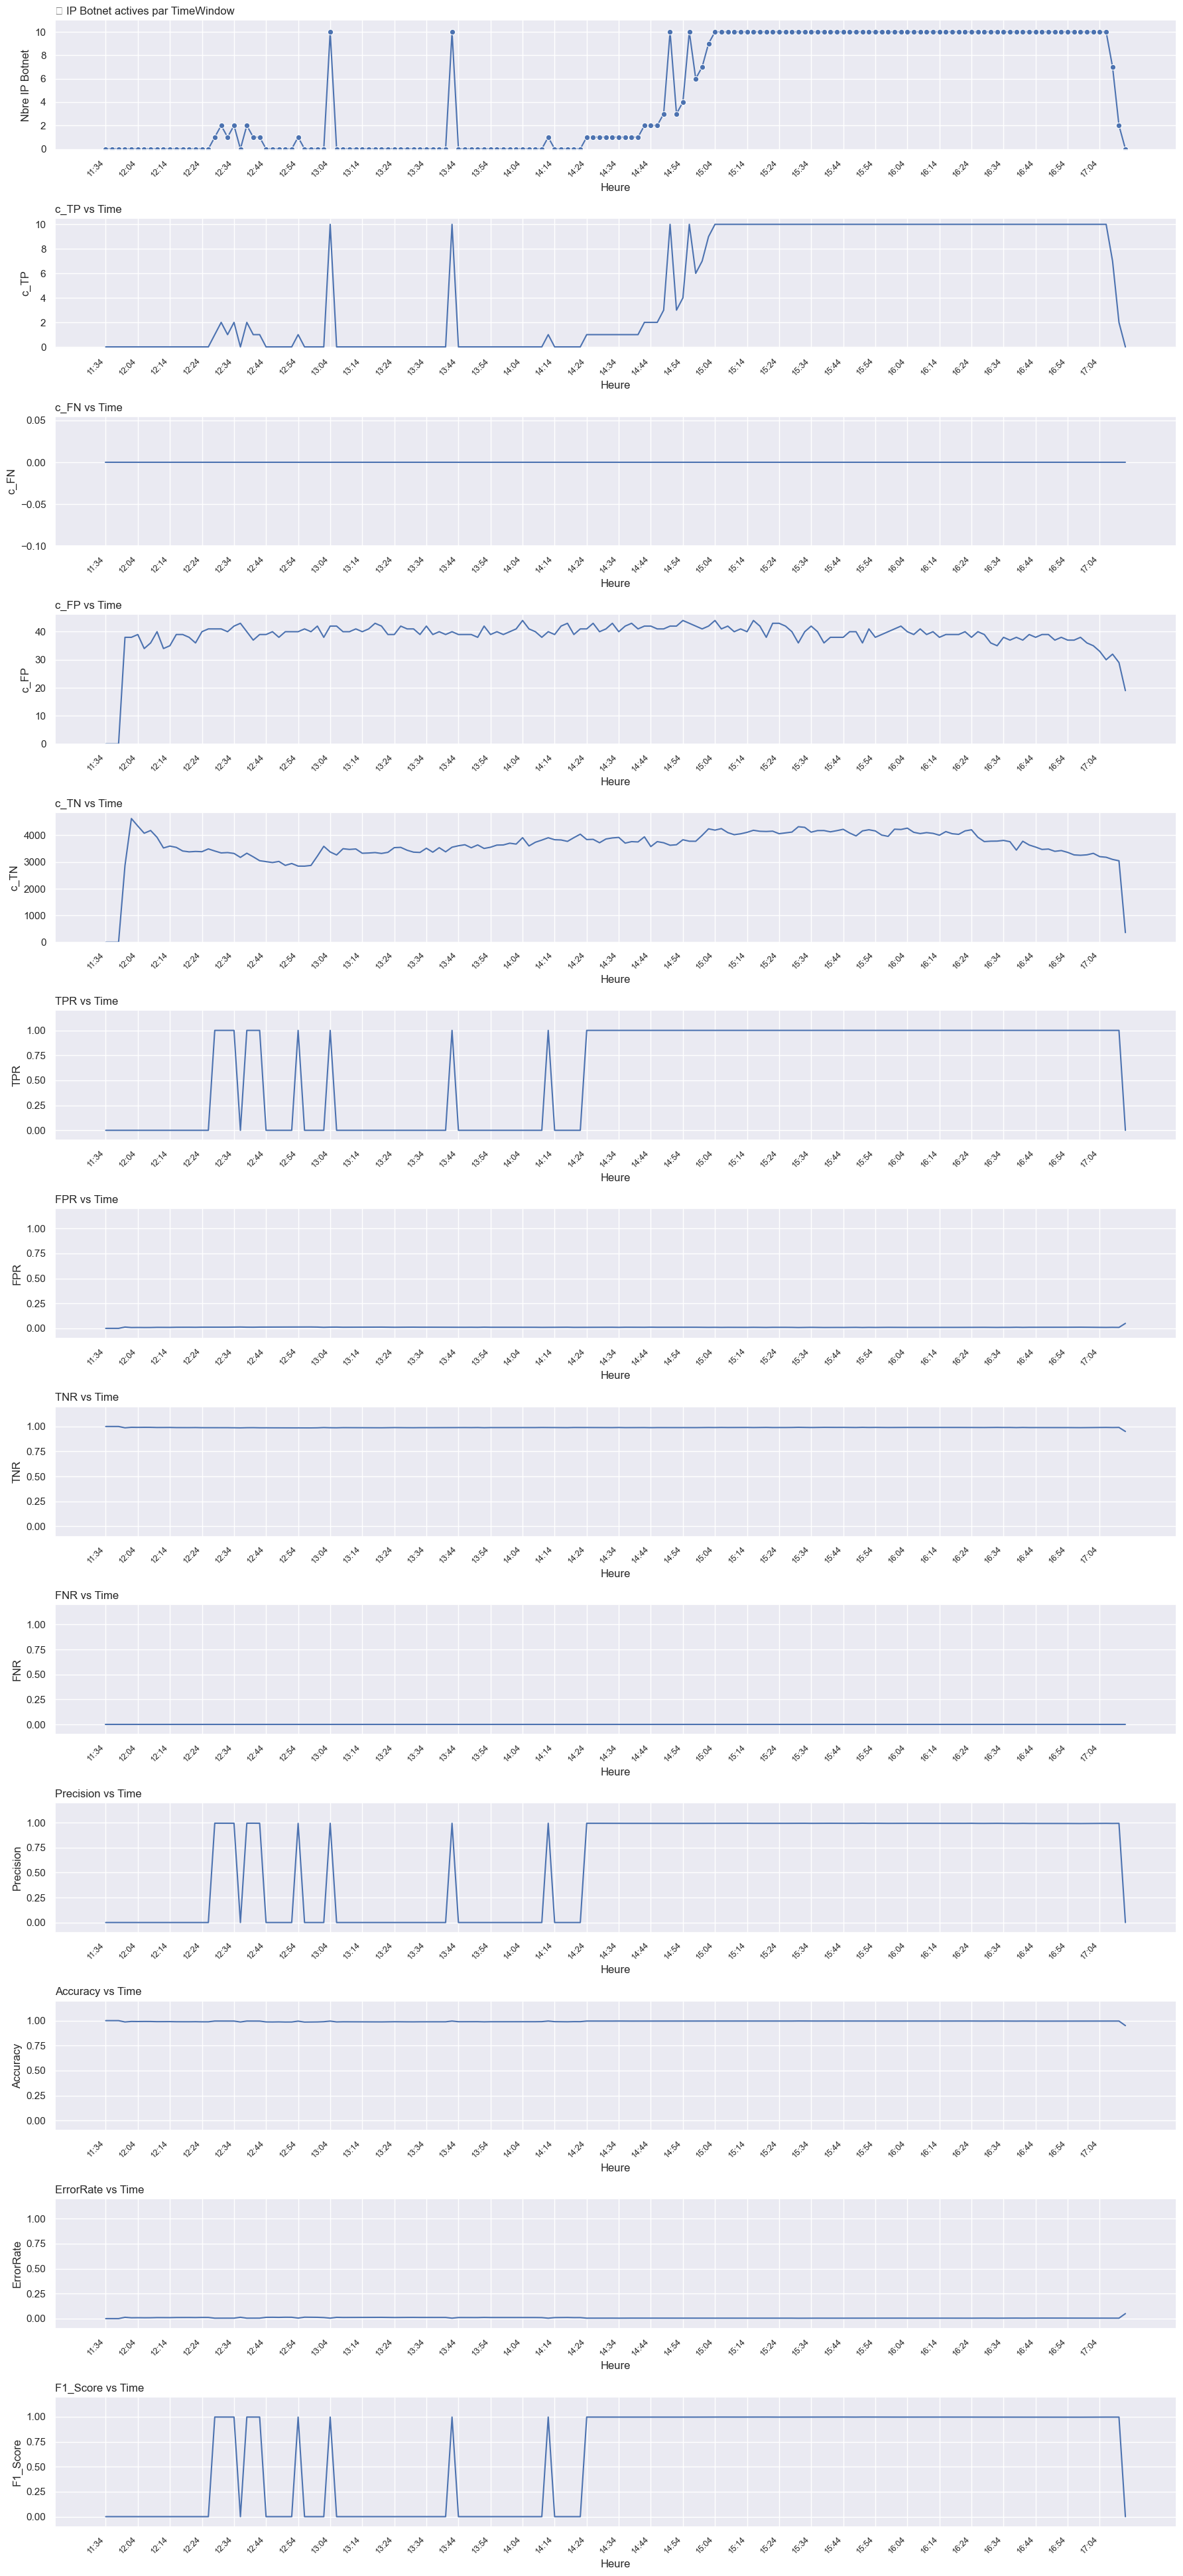

In [119]:
def plot_botnet_and_metrics_subplots(df_classified_netflows, df_metrics, x_tick_spacing=4):
    """
    Affiche en sous-graphes :
    1. Le nombre d’IP Botnet actives (réelles) par TimeWindow.
    2. Les métriques XU classiques (TPR, FPR, etc.) au fil du temps.

    Paramètres :
    - df_classified_netflows : DataFrame avec colonnes ['TimeWindow', 'SrcIP', 'Label']
    - df_metrics : DataFrame avec les colonnes métriques par TimeWindow
    - x_tick_spacing : espacement des ticks X (int)
    """

    print("📊 ➤ Fusion : Botnet Activity + XU Metrics")

    # ────────────── Nombres de bots Actifs (Ground Truth) ──────────────
    all_timewindows = df_classified_netflows['TimeWindow'].dropna().sort_values().unique()
    all_time_df = pd.DataFrame({'TimeWindow': all_timewindows})

    botnet_flows = df_classified_netflows[df_classified_netflows['Label'] == 'Botnet']
    botnet_activity = botnet_flows.groupby('TimeWindow')['SrcIP'].nunique().reset_index(name='BotnetUniqueIPs')

    # Ajouter les TimeWindows manquants avec 0
    botnet_activity = all_time_df.merge(botnet_activity, on='TimeWindow', how='left').fillna(0)
    botnet_activity['BotnetUniqueIPs'] = botnet_activity['BotnetUniqueIPs'].astype(int)
    botnet_activity['TimeLabel'] = botnet_activity['TimeWindow'].dt.strftime('%H:%M')


    # ────────────── Préparer df_metrics ──────────────
    df_plot = df_metrics.copy().sort_values('TimeWindow')
    df_plot['TimeLabel'] = df_plot['TimeWindow'].dt.strftime('%H:%M')


    metrics_to_plot = ['BotnetUniqueIPs', 'c_TP', 'c_FN', 'c_FP', 'c_TN',
                       'TPR', 'FPR', 'TNR', 'FNR', 'Precision', 'Accuracy', 'ErrorRate', 'F1_Score']

    n_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(18, 3 * n_metrics), sharex=False)

    # Préparer les ticks X (partagés)
    x_ticks = np.arange(0, len(df_plot['TimeLabel']), x_tick_spacing)
    x_tick_labels = df_plot['TimeLabel'].iloc[x_ticks]

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        if metric == 'BotnetUniqueIPs':
            sns.lineplot(data=botnet_activity, x='TimeLabel', y='BotnetUniqueIPs', marker='o', ax=ax)
            ax.set_title("📈 IP Botnet actives par TimeWindow", loc='left')
            ax.set_ylabel("Nbre IP Botnet")
            ax.set_ylim(-0.1, 11)
        else:
            sns.lineplot(data=df_plot, x='TimeLabel', y=metric, ax=ax)
            ax.set_title(f"{metric} vs Time", loc='left')
            ax.set_ylabel(metric)
            ax.set_ylim(-0.1, 1.2 if metric not in ['BotnetUniqueIPs', 'c_TP', 'c_FN', 'c_FP', 'c_TN'] else None)

        ax.grid(True)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_tick_labels, rotation=45, ha='right', fontsize=9)
        ax.set_xlabel("Heure")

    plt.tight_layout()
    plt.show()

plot_botnet_and_metrics_subplots(df_classified_netflows, df_metrics, x_tick_spacing=5)


In [ ]:
def display_flows_in_timewindow(df, start_time_str, window_duration='2Min'):
    """
    Affiche les flux NetFlows dans une TimeWindow de durée fixe à partir d'un temps de départ.

    Paramètres :
    - df : DataFrame des NetFlows avec la colonne 'flow_start' au format datetime
    - start_time_str : chaîne du temps de départ (ex: '2011-08-17 12:01:12')
    - window_duration : durée de la TimeWindow (ex: '2Min', '5Min', etc.)

    Retour :
    - DataFrame filtré (affiché également)
    """
    start_time = pd.to_datetime(start_time_str)
    end_time = start_time + pd.to_timedelta(window_duration)

    df_filtered = df[(df['flow_start'] >= start_time) & (df['flow_start'] < end_time)]

    print(f"\n➡️ Flux entre {start_time} et {end_time} ({window_duration}) :")
    display_scrollable_dataframe(df_filtered, max_height=400)

    return

In [ ]:
display_flows_in_timewindow(df_classified_netflows[df_classified_netflows["Label"] == "Botnet"], '2011-08-17 13:04:00', window_duration='1Min')


# I don't know

In [ ]:
def display_confusion_matrix(y_true, y_pred):
    """
    Affiche un tableau structuré avec les métriques de classification :
    TP, TN, FP, FN et le rapport de classification détaillé.

    Paramètres :
    - y_true : Liste des vraies étiquettes (Normal/Botnet)
    - y_pred : Liste des prédictions du modèle (Normal/Botnet)
    """
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred, labels=['Normal', 'Botnet'])
    print(cm)
    # Extraction des valeurs TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    
    # Création d'un DataFrame pour afficher sous forme de tableau 2x2
    confusion_df = pd.DataFrame(
        [[f"TN: {tn}", f"FP: {fp}"],
         [f"FN: {fn}", f"TP: {tp}"]],
        index=["Actual Normal", "Actual Botnet"],
        columns=["Predicted Normal", "Predicted Botnet"]
    )

    # Affichage du tableau
    print("\n📊 **Matrice de Confusion & Résumé des métriques**")
    display(confusion_df)
    
    # Génération du rapport de classification
    classification_rep = classification_report(y_true, y_pred, labels=['Normal', 'Botnet'], output_dict=True)
    classification_df = pd.DataFrame(classification_rep).transpose()

    # Affichage du rapport détaillé
    print("\n📑 **Rapport de Classification**")
    display(classification_df)


In [ ]:
y_true = df_features['Label']
y_pred = df_features['Predicted']

display_confusion_matrix(y_true, y_pred)

### Flow-level metrics
Si l'on veut évaluer plus finement au niveau **flow** :
1. Merge `df_features` dans `df` sur la colonne `SrcAddr`.
2. Si un IP est classé Botnet, tous ses flux deviennent Botnet.
3. On compare `df['Label']` et `df['PredictedFlow']`.

In [ ]:
# 1. Merge
df_merged = df.merge(df_features[['SrcIP','Predicted']], on='SrcIP', how='left')
df_merged['PredictedFlow'] = df_merged['Predicted']

# 2. On compare
y_true_fl = df_merged['Label']
y_pred_fl = df_merged['PredictedFlow']

cm_fl = confusion_matrix(y_true_fl, y_pred_fl, labels=['Normal','Botnet'])
tn, fp, fn, tp = cm_fl.ravel()

print("Matrice de confusion (Flow-level) :")
print(cm_fl)
print(classification_report(y_true_fl, y_pred_fl, labels=['Normal','Botnet']))

In [ ]:
def plot_anomaly_score_histogram_with_counts(df_features):
    """
    Affiche un histogramme de la distribution des scores d'anomalie (AnomalyScore) 
    avec les nombres d'occurrences affichés sur chaque barre.

    Paramètre :
    - df_features : DataFrame contenant une colonne 'AnomalyScore'.

    Affichage :
    - Un histogramme montrant la répartition des scores d'anomalie avec les effectifs sur les barres.
    """

    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(df_features['AnomalyScore'], bins=30, color='blue', edgecolor='black', alpha=0.7)

    # Ajouter les étiquettes de fréquence au-dessus des barres
    for count, bin_patch in zip(counts, patches):
        if count > 0:  # Éviter d'afficher les valeurs nulles
            plt.text(bin_patch.get_x() + bin_patch.get_width() / 2, count, 
                     f"{int(count)}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title('Distribution des Scores d\'Anomalie', fontsize=14, fontweight='bold')
    plt.xlabel('AnomalyScore', fontsize=12)
    plt.ylabel('Nombre d\'occurrences', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()

plot_anomaly_score_histogram_with_counts(df_features)


In [ ]:
def display_botnet_anomaly_scores(df_features):
    """
    Affiche les scores d'anomalie des adresses IP taguées comme Botnet sous forme de tableau.

    Paramètre :
    - df_features : DataFrame contenant les colonnes 'SrcAddr', 'AnomalyScore' et 'Label'.

    Affichage :
    - Un tableau des adresses IP Botnet avec leurs scores d'anomalie.
    """

    # Filtrer uniquement les adresses taguées comme Botnet
    botnet_scores_df = df_features[df_features['Label'] == 'Botnet'][['SrcIP', 'AnomalyScore']].reset_index(drop=True)

    return botnet_scores_df

botnet_scores_df = display_botnet_anomaly_scores(df_features)
botnet_scores_df

In [ ]:
def preprocessing_dataset(df):
    """
    Sépare les informations d'IP et de port pour les colonnes 'SrcIPAddr:Port' et 'DstIPAddr:Port'.
    
    La fonction fait :
    - La séparation en deux colonnes pour chacune des colonnes concernées.
    - La suppression des colonnes d'origine.
    - La réorganisation des colonnes afin que les deux nouvelles colonnes remplacent la colonne d'origine
      (les ports se retrouvent à droite de leur adresse IP).
    
    Retourne le DataFrame modifié.
    """
    # Effectuer la séparation pour la source
    src_split = df["SrcIPAddr:Port"].str.split(":", expand=True)
    df["SrcIP"] = src_split[0]
    df["SrcPort"] = src_split[1]
    
    # Effectuer la séparation pour la destination
    dst_split = df["DstIPAddr:Port"].str.split(":", expand=True)
    df["DstIP"] = dst_split[0]
    df["DstPort"] = dst_split[1]
    
    # Sauvegarder l'ordre original connu
    original_cols = ["Date", "flow_start", "Durat", "Prot", 
                     "SrcIPAddr:Port", "Direc", "DstIPAddr:Port", 
                     "Flags", "Tos", "Packets", "Bytes", "Flows", "Label"]
    
    # Trouver les positions des colonnes à remplacer
    src_idx = original_cols.index("SrcIPAddr:Port")
    dst_idx = original_cols.index("DstIPAddr:Port")
    
    # Construire le nouvel ordre des colonnes :
    # - Conserver les colonnes avant la colonne source d'origine.
    new_order = original_cols[:src_idx]
    # - Remplacer "SrcIPAddr:Port" par "SrcIP" et "SrcPort"
    new_order.extend(["SrcIP", "SrcPort"])
    # - Conserver les colonnes entre la colonne source et la colonne destination d'origine
    new_order.extend(original_cols[src_idx+1:dst_idx])
    # - Remplacer "DstIPAddr:Port" par "DstIP" et "DstPort"
    new_order.extend(["DstIP", "DstPort"])
    # - Conserver le reste des colonnes après la colonne destination d'origine
    new_order.extend(original_cols[dst_idx+1:])
    
    # Supprimer les colonnes d'origine
    df = df.drop(columns=["SrcIPAddr:Port", "DstIPAddr:Port"])
    
    # Réorganiser le DataFrame selon le nouvel ordre
    df = df[new_order]
    
    return df